In [1]:

from  PIL import Image 
import numpy as np
 

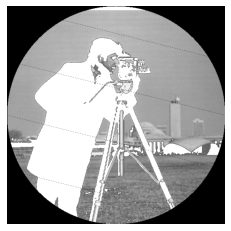

In [2]:
import numpy as np
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
camera[:10] = 0
mask = camera < 87
camera[mask] = 255
inds_x = np.arange(len(camera))
inds_y = (4 * inds_x) % len(camera)
camera[inds_x, inds_y] = 0

l_x, l_y = camera.shape[0], camera.shape[1]
X, Y = np.ogrid[:l_x, :l_y]
outer_disk_mask = (X - l_x / 2)**2 + (Y - l_y / 2)**2 > (l_x / 2)**2
camera[outer_disk_mask] = 0

plt.figure(figsize=(4, 4))
plt.imshow(camera, cmap='gray')
plt.axis('off')
plt.show()

## Single color


In [3]:
import numpy as np

im = np.array(Image.open('img/1.jpg'))
print(im)
im_R = im.copy()
im_R[:, :, (1, 2)] = 0
im_G = im.copy()
im_G[:, :, (0, 2)] = 0
im_B = im.copy()
im_B[:, :, (0, 1)] = 0

im_RGB = np.concatenate((im_R, im_G, im_B), axis=1)
# im_RGB = np.vstack((im_R, im_G, im_B))
# im_RGB = np.c_['1', im_R, im_G, im_B]

pil_img = Image.fromarray(im_RGB)
pil_img.save('img/single_colorpic.jpg')

[[[  0 131 252]
  [  0 131 252]
  [  0 131 252]
  ...
  [ 67 155 253]
  [ 68 156 254]
  [ 68 156 254]]

 [[  0 132 253]
  [  0 132 253]
  [  0 132 253]
  ...
  [ 66 154 252]
  [ 67 155 253]
  [ 67 155 253]]

 [[  0 132 253]
  [  0 132 253]
  [  0 132 253]
  ...
  [ 66 154 252]
  [ 66 154 252]
  [ 66 154 252]]

 ...

 [[  0  21   0]
  [  0  22   0]
  [  3  26   0]
  ...
  [  0   1   0]
  [  0   3   1]
  [  0   5   2]]

 [[ 11  37   2]
  [ 12  38   3]
  [ 16  42   5]
  ...
  [  0   0   2]
  [  0   2   3]
  [  0   3   3]]

 [[ 26  54  14]
  [ 25  53  13]
  [ 25  56  15]
  ...
  [  3   4   8]
  [  3   4   6]
  [  0   4   5]]]


## Negative / positive inversion (invert pixel value)
It is also easy to calculate and manipulate pixel values.

A negative-positive inverted image can be generated by subtracting the pixel value from the max value (255 for uint8).

In [4]:
import numpy as np
from PIL import Image
#do it with gray image to get negative pic
#im = np.array(Image.open('img_tiger_grey.jpg').resize((256, 256)))
im = np.array(Image.open('img/1.jpg').resize((256, 256)))
print(im[0:2])
im_i = 255 - im
print()
print(im_i[0:2])
Image.fromarray(im_i).save('img/neg-pos-1.png')


[[[  0 132 253]
  [  0 132 253]
  [  0 130 252]
  ...
  [ 69 157 255]
  [ 67 155 253]
  [ 66 154 252]]

 [[  0 132 253]
  [  0 132 253]
  [  0 130 252]
  ...
  [ 66 157 254]
  [ 66 157 254]
  [ 66 156 253]]]

[[[255 123   2]
  [255 123   2]
  [255 125   3]
  ...
  [186  98   0]
  [188 100   2]
  [189 101   3]]

 [[255 123   2]
  [255 123   2]
  [255 125   3]
  ...
  [189  98   1]
  [189  98   1]
  [189  99   2]]]


## Paste with slice¶
By using this, a part of the image or the entire image can be pasted to another image.

In [5]:
from PIL import Image

src = np.array(Image.open('img/1.jpg').resize((128, 128)))
dst = np.array(Image.open('img/2.jpg').resize((256, 256))) // 4 #to change color

dst_copy = dst.copy()
dst_copy[64:128, 128:192] = src[32:96, 32:96] #should be same

Image.fromarray(dst_copy).save('img/12mix.jpg')

Note that an error will occur if the size of the area specified on the left side differs from the size of the area specified on the right side.

In [6]:
dst_copy = dst.copy()
dst_copy[64:192, 64:192] = src

Image.fromarray(dst_copy).save('img/12mix1.jpg')

## Alpha blending and masking¶
By the operation for each element (= pixel) of the array, two images can be alpha-blended or composited based on a mask image. See the following articles for details.

In [7]:
from PIL import Image

src1 = np.array(Image.open('img/1.jpg'))
print(src1.shape[1::-1])
src2 = np.array(Image.open('img/2.jpg').resize(src1.shape[1::-1], Image.BILINEAR))

print(src1.dtype)

dst = src1 * 0.5 + src2 * 0.5

print(dst.dtype)
# float64

Image.fromarray(dst.astype(np.uint8)).save('img/after_blending.jpg')

(1024, 640)
uint8
float64


## Block views on images/arrays
Block views can be incredibly useful when one wants to perform local operations on non-overlapping image patches.

We use astronaut from skimage.data and virtually ‘slice’ it into square blocks. Then, on each block, we either pool the mean, the max or the median value of that block. The results are displayed altogether, along with a spline interpolation of order 3 rescaling of the original astronaut image.


128


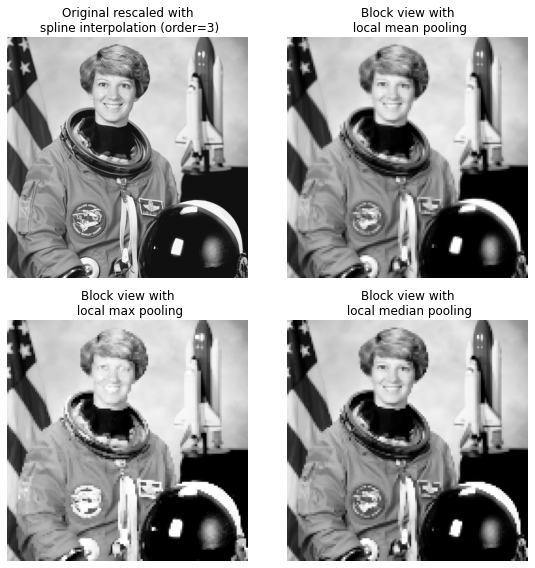

In [8]:
import numpy as np
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from skimage import data
from skimage import color
from skimage.util import view_as_blocks


# get astronaut from skimage.data in grayscale
l = color.rgb2gray(data.astronaut())

# size of blocks
block_shape = (4, 4)

# see astronaut as a matrix of blocks (of shape block_shape)
view = view_as_blocks(l, block_shape)
print(view.shape[0])
# collapse the last two dimensions in one
flatten_view = view.reshape(view.shape[0], view.shape[1], -1)

# resampling the image by taking either the `mean`,
# the `max` or the `median` value of each blocks.
mean_view = np.mean(flatten_view, axis=2)
max_view = np.max(flatten_view, axis=2)
median_view = np.median(flatten_view, axis=2)

# display resampled images
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

l_resized = ndi.zoom(l, 2, order=3)
ax[0].set_title("Original rescaled with\n spline interpolation (order=3)")
ax[0].imshow(l_resized, extent=(-0.5, 128.5, 128.5, -0.5),
             cmap=cm.Greys_r)

ax[1].set_title("Block view with\n local mean pooling")
ax[1].imshow(mean_view, cmap=cm.Greys_r)

ax[2].set_title("Block view with\n local max pooling")
ax[2].imshow(max_view, cmap=cm.Greys_r)

ax[3].set_title("Block view with\n local median pooling")
ax[3].imshow(median_view, cmap=cm.Greys_r)

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [9]:
import numpy as np
from skimage.util.shape import view_as_blocks
A = np.arange(4*4).reshape(4,4)

B = view_as_blocks(A, block_shape=(2, 2))
#1st quad
print(B[0, 0])

#2nd quad
print(B[0, 1])

#3rd quad
B[1, 0, 1, 1]
#will show 13

A = np.arange(4*4*6).reshape(4,4,6)
print(A)
B = view_as_blocks(A, block_shape=(1, 2, 2))
print("shape of b is ",B.shape)

print(B[2:, 0, 2])  # doctest: +NORMALIZE_WHITESPACE


[[0 1]
 [4 5]]
[[2 3]
 [6 7]]
[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]
  [12 13 14 15 16 17]
  [18 19 20 21 22 23]]

 [[24 25 26 27 28 29]
  [30 31 32 33 34 35]
  [36 37 38 39 40 41]
  [42 43 44 45 46 47]]

 [[48 49 50 51 52 53]
  [54 55 56 57 58 59]
  [60 61 62 63 64 65]
  [66 67 68 69 70 71]]

 [[72 73 74 75 76 77]
  [78 79 80 81 82 83]
  [84 85 86 87 88 89]
  [90 91 92 93 94 95]]]
shape of b is  (4, 2, 3, 1, 2, 2)
[[[[52 53]
   [58 59]]]


 [[[76 77]
   [82 83]]]]
